In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import datetime
from langchain.agents import tool, create_react_agent
from langchain_community.tools import TavilySearchResults
from langchain import hub
load_dotenv()

True

In [2]:
llm_model = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash',
                                    temperature = 0,
                                    max_tokens=None,
                                    timeout=None,
                                    max_retries=2)

In [5]:
@tool
def get_system_time(format: str = "%Y-%m-%d %H:%M:%S"):
    """ Returns the current date and time in the specified format """
    
    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime(format)
    return formatted_time

search_tool = TavilySearchResults(search_depth="basic")
react_prompt = hub.pull("hwchase17/react")

tools = [get_system_time, search_tool]
##creating the react agent runnable
react_agent_runnable = create_react_agent(tools=tools, llm=llm_model, prompt=react_prompt)

In [22]:
## REACT Prompt Template
react_prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}')

In [10]:
##reach state##
from typing import List,Annotated,TypedDict,Union,List
import operator
from langchain_core.agents import AgentAction,AgentFinish

class AgentState(TypedDict):
    input: str ##HumanMessage, stays constant
    agent_outcome: Union[AgentAction,AgentFinish, None]
    '''
    AgentAction	--> Tool call decision	-->> Tool is executed
    AgentFinish	-->> Final output (user answer)-->>	Loop ends
    None -->> initial is None, Union means any 3 can happen
    '''
    intermediate_steps: Annotated[List[tuple[AgentAction,str]],operator.add]

In [11]:
##Building the Nodes##
def reasonNode(state: AgentState):
    agent_outcome = react_agent_runnable.invoke(state)
    return {'agent_outcome':agent_outcome}

In [16]:
def actNode(state:AgentState):
    agent_action = state['agent_outcome']
    ###Extract the tool name and tool input
    tool_name = agent_action.tool
    tool_input = agent_action.tool_input

    ###finding the matching tool name##
    tool_function = None
    for tool in tools:
        if tool.name == tool_name:
            tool_function = tool
            break

    ## exceution##
    if tool_function:
        if isinstance(tool_input,dict):
            output = tool_function.invoke(**tool_input)
        else:
            output = tool_function.invoke(tool_input)

    else:
        output = f"Tool '{tool_name}' not found"

    return {"intermediate_steps":[(agent_action,str(output))]} ##list of tuples with agentaction and output of the tool

In [17]:
from langgraph.graph import END,StateGraph
REASON_NODE = "reason_node"
ACT_NODE = "act_node"

def should_continue(state:AgentState)->str:
    if isinstance(state['agent_outcome'],AgentFinish):
        return END
    else:
        return ACT_NODE

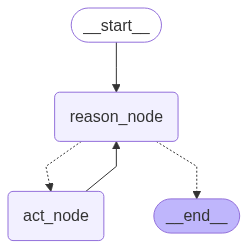

In [20]:
## Build the graph##
graph = StateGraph(AgentState)
## Adding Nodes ###
graph.add_node(REASON_NODE,reasonNode)
graph.add_node(ACT_NODE,actNode)
graph.set_entry_point(REASON_NODE)

##conditional edge from REASON NODE based on AgentAction (ActNode)or AgentFinish(END)
graph.add_conditional_edges(REASON_NODE,should_continue)
graph.add_edge(ACT_NODE,REASON_NODE)

app = graph.compile()
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()
display(Image(png))

In [23]:
result = app.invoke(
    {
        "input":"How many days ago did India win the T20 World Cup?",
        "agent_outcome":None,
        "intermediate_steps":[]
    }   
) ###invoking the app using input, the agent_outcome,intermediate_steps

In [24]:
print(result)
##AgentFinish shows the output

{'input': 'How many days ago did India win the T20 World Cup?', 'agent_outcome': AgentFinish(return_values={'output': 'India won the T20 World Cup on June 29, 2024. Today is June 30, 2025. Therefore, India won the T20 World Cup 366 days ago.'}, log='Final Answer: India won the T20 World Cup on June 29, 2024. Today is June 30, 2025. Therefore, India won the T20 World Cup 366 days ago.\n'), 'intermediate_steps': [(AgentAction(tool='tavily_search_results_json', tool_input='When did India win the T20 World Cup?', log='I need to find out when India won the T20 World Cup and then calculate the number of days between that date and today. First, I\'ll use the search engine to find out when India won the T20 World Cup.\nAction: tavily_search_results_json\nAction Input: "When did India win the T20 World Cup?"'), '[{\'url\': "https://en.wikipedia.org/wiki/India_at_the_Men\'s_T20_World_Cup", \'content\': "India is one of the full members of the International Cricket Council (ICC), the governing bo

In [27]:
print("Final Result:\n",result['agent_outcome'].return_values["output"])

Final Result:
 India won the T20 World Cup on June 29, 2024. Today is June 30, 2025. Therefore, India won the T20 World Cup 366 days ago.
